# Totorial 3 10x Visium DLPFC

## Import relevant packages

In [ ]:
import sys
sys.path.append("..")
import STWave
import scanpy as sc
import pandas as pd
from sklearn.metrics import adjusted_rand_score


## Read data

In [5]:
adata = sc.read_visium(r'/home/guo/jt/data/DLPFC/151675')
adata

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Read ground truth 

In [6]:
trurh_df = pd.read_csv(r'/home/guo/jt/data/DLPFC/151675_truth.txt',header=None,sep='\t',index_col=0)
trurh_df.shape

(3592, 1)

In [7]:
trurh_df = trurh_df.reindex(adata.obs_names)
trurh_df.shape

(3592, 1)

In [8]:
adata.obs['truth'] = trurh_df.iloc[:,0].values
adata

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Filter and select highly variable genes

In [9]:
STWave.prefilter_genes(adata,min_cells=3)
adata = STWave.svg(adata,svg_method='seurat_v3',n_top=3000)
adata

AnnData object with n_obs × n_vars = 3592 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

## Construct spatial networks and pruning networks

In [10]:
STWave.Cal_Spatial_Net(adata,rad_cutoff=150,model='Radius',verbose=True)
STWave.Cal_Precluster_Net(adata,verbose=True)
adata

------Calculating spatial graph...
Spatial graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
Spatial graph calculation time: 0.04 seconds
------Calculating precluster graph...
Precluster spatial graph contains 15982 edges, 3592 cells.
4.4493 neighbors per cell on average.
Precluster graph calculation time: 3.48 seconds


AnnData object with n_obs × n_vars = 3592 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial'

## Train the STWave model
 ```STWave.Trainer()``` Args
 - dim_reduction (str, optional): Dimensional reduction method ('PCA', 'HVG', or None). Defaults to 'PCA'.
 - batch_data (bool, optional): Whether to split data into batches for training, defaults to False.
 - num_batch_x_y (Tuple[int, int], optional): Number of batches along x and y axes if batch_data=True, defaults to None.
 - device ('cuda', 'cpu'): 'cuda' or 'cpu'.
- 

In [11]:
trainer = STWave.Trainer(adata,dim_reduction='HVG',batch_data=False,device='cuda')

check PyG Data object device：

x: shape=(3592, 3000), device=cpu, dtype=torch.float32
edge_index: shape=(2, 43928), device=cpu, dtype=torch.int64
edge_type: shape=(43928,), device=cpu, dtype=torch.int64
------Using device: cuda:0
------Using default weights:  {'w_recon': 1, 'w_wave': 20}


```Trainer.train()``` Args
- hidden_dims (List[int], optional): Hidden dimensions for STWaveNet, defaults to [100, 32].
- n_epochs (int, optional): Number of training epochs, defaults to 200.
- save_reconstrction (bool, optional): If True, saves reconstructed data in adata.obsm, defaults to True.

In [12]:
trainer.train(hidden_dims=[256,64],n_epochs=500)
adata

using wavelet: db4
deconposing levels: 3
------training batch...


100%|██████████| 500/500 [00:27<00:00, 18.32it/s, _1loss=1.1, _2loss_recon=0.0553, _3loss_wave=0.0525] 


------inferencing...
------saving embeddings...
------saving reconstrction...


AnnData object with n_obs × n_vars = 3592 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial', 'STWave', 'STWave_ReX'

## Performing clustering

In [13]:
STWave.mclust_R(adata,used_obsm='STWave',num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 3592 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial', 'STWave', 'STWave_ReX', 'emb_pca'

## Calculating the ARI score and visualization

In [14]:
truth_labels = adata[~adata.obs['truth'].isnull()].obs['truth'].values
pre_labels = adata[~adata.obs['truth'].isnull()].obs['mclust'].values
truth_labels.shape,pre_labels.shape

((3566,), (3566,))

In [15]:
ari = adjusted_rand_score(truth_labels,pre_labels)
print('ARI:',ari)

ARI: 0.6323631388210593


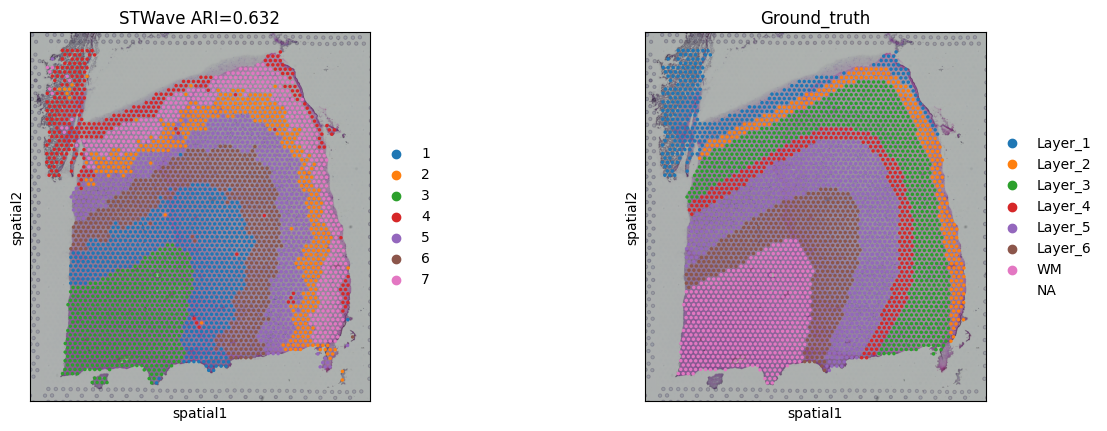

In [17]:
sc.pl.spatial(adata, color=['mclust', 'truth'],title=[f'STWave ARI={ari:.3f}' ,'Ground_truth'])